In [1]:
from Bio import SeqIO
from Bio.Data import CodonTable
import pandas as pd

We will create a function named **get_sequences_from_file** and it will take as input any fasta file here called "fasta_fn"

They create a dictionnary 

A forloop can be used which for every record in fasta file will first separate the description and then creates  string species name. Species name is composed of two elements: second and third element of the description. 

Next, we use each species name as a key in the dictionnary and add the sequence as its value. 


This code is used to parse the fasta file. 

This should work using BioPython (be sure to check what this returns)

In [2]:
def get_sequences_from_file(fasta_fn):
    sequence_data_dict = {}
    for record in SeqIO.parse(fasta_fn, "fasta"):
        description = record.description.split()
        species_name = description[1] + " " + description[2]
        sequence_data_dict[species_name] = record.seq
    return(sequence_data_dict)

In [3]:
d = get_sequences_from_file('penguins_cytb.fasta')

In [4]:
d['Aptenodytes forsteri']

Seq('ATGGCCCCAAATCTCCGAAAATCCCATCCCCTCCTAAAAATAATTAATAACTCC...TAA', SingleLetterAlphabet())

To translate the sequence of interest, we use **translate_function**, and from the Codon Table created by NCBI, we chose **vertebrate mitochondria**. Therefore we can use this table to translate each codon to its corresponding amino acid. Then we use aa_seq_string = [] which is an empty list to transfer the outcome (aa sequence) in there. we chose the very firsst aa as first index (index=0) and define a codon as three nucleotides (index:index+3).  Then we use **if** to avoid chosing stop codons. 

In [5]:
def translate_function(string_nucleotides):
    mito_table = CodonTable.unambiguous_dna_by_name["Vertebrate Mitochondrial"]
    aa_seq_string = []
    index = 0
    
    for pos in range(0, len(string_nucleotides)//3):
        codon = string_nucleotides[index:index+3]
        index += 3
        
        if codon == "TAA" or codon == "TAG" or codon == "AGA" or codon == "AGG":
            break 
        else: 
            aa = mito_table.forward_table[codon]
            aa_seq_string.append(aa)
            
    return(aa_seq_string)
        

In [6]:
from Bio.Alphabet import generic_dna
from Bio.Seq import Seq

Below is the alternative method of translating a sequence using **translate**, table #2 is for mitochondria and we ask to stop when reaching to a stop codon. 

In [7]:
def other_translation(dna_seq):
    sequence = Seq(str(dna_seq), generic_dna)
    aa_seq = sequence.translate(table = 2, to_stop = True)
    return(aa_seq)

Below we use **Bio.SeqUtils.ProtParam** and extract the **ProteinAnalysis** to calculate the molecular mass of the polypeptide sequence. First we make a string from aa sequence,  then we ask to calculate molecular mass. Next we calculate the GC pecent by counting the number of all Gs and  Cs followed by multipling the sum in 100 and deviding it by the length of the coding sequence. 

In [8]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis 

In [9]:
def calculate_molecular_mass(aa_seq):
    analyzed_seq = ProteinAnalysis(str(aa_seq))
    m_mass= analyzed_seq.molecular_weight()
    return(m_mass)

In [10]:
def gc_content(dna_seq):
    count = dna_seq.count("G") + dna_seq.count("C")
    gc = 100 * count / len(dna_seq)
    return(gc)

Below we extract the sequence which is in fasta file from a dectionnary file (cytb_seqs).

In [11]:
cytb_seqs = get_sequences_from_file("penguins_cytb.fasta") 
penguins_df = pd.read_csv("penguins_mass.csv") 
species_list = list(penguins_df.species)

Below we add two columns to the **penguins_df** file using "import numpy as np" while "numpy" will add "NaN" in empty cells. Then we dictate to take the penguin_df file and assign two additional columns to it: molecular weight and GC contect. 

In [12]:
import numpy as np
penguins_df = penguins_df.assign(Molecular_weight = np.nan, GC_content = np.nan) 

In [28]:
for key, value in cytb_seqs.items():
    aa_seq = other_translation(value)
    mol_weight = calculate_molecular_mass(aa_seq)
    gc_cont = gc_content(value)
    index = penguins_df[penguins_df["species"] == key].index
    penguins_df.Molecular_weight[index] = mol_weight
    penguins_df.GC_content[index] = gc_cont

C:\Users\hazin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hazin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Below we plot the bar graph.  first we need to load a library. The smallest penguin species is Eudyptula minor. Interesting fact: they are called fairy penguins because if they small size.  

In [45]:
%matplotlib inline

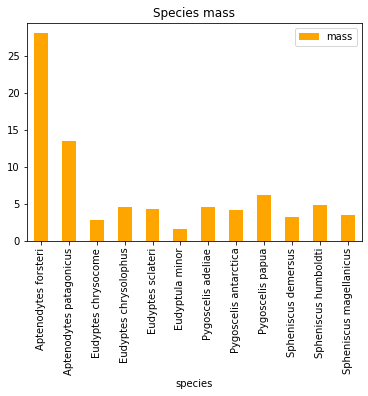

In [46]:
penguins_df.plot(x = "species", y = "mass", kind = "bar", color = "orange", 
                title = "Species mass")

In [24]:
import seaborn as sbn

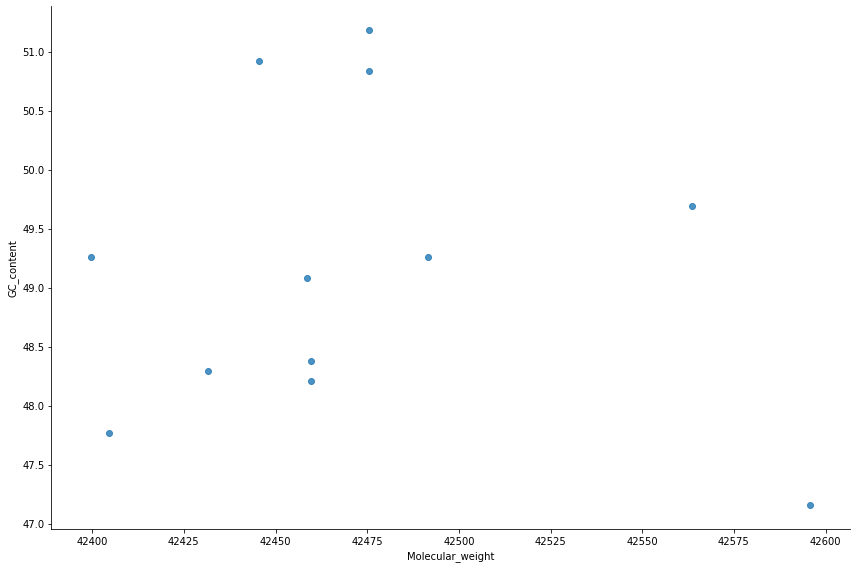

In [30]:
sbn.lmplot("Molecular_weight", "GC_content", data = penguins_df, 
           fit_reg = False, height = 8, aspect = 1.5)

In [29]:
print (penguins_df)
print (species_list)

                    species   mass  Molecular_weight  GC_content
0      Aptenodytes forsteri  28.00        42459.6021   48.381452
1   Aptenodytes patagonicus  13.40        42563.7067   49.693788
2       Eudyptes chrysocome   2.80        42475.5753   51.181102
3     Eudyptes chrysolophus   4.50        42445.5493   50.918635
4         Eudyptes sclateri   4.25        42475.5753   50.831146
5           Eudyptula minor   1.60        42491.6408   49.256343
6        Pygoscelis adeliae   4.60        42458.6140   49.081365
7     Pygoscelis antarctica   4.10        42404.5423   47.769029
8          Pygoscelis papua   6.10        42595.8759   47.156605
9       Spheniscus demersus   3.20        42431.5490   48.293963
10     Spheniscus humboldti   4.75        42399.5520   49.256343
11  Spheniscus magellanicus   3.40        42459.6021   48.206474
['Aptenodytes forsteri', 'Aptenodytes patagonicus', 'Eudyptes chrysocome', 'Eudyptes chrysolophus', 'Eudyptes sclateri', 'Eudyptula minor', 'Pygoscelis ade

Below is the answer to the bonus question: 

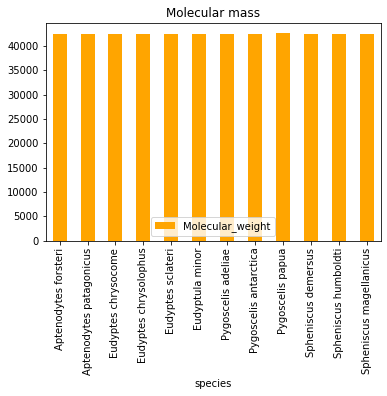

In [48]:
penguins_df.plot(x = "species", y = "Molecular_weight", kind = "bar", color = "orange", 
                title = "Molecular mass")

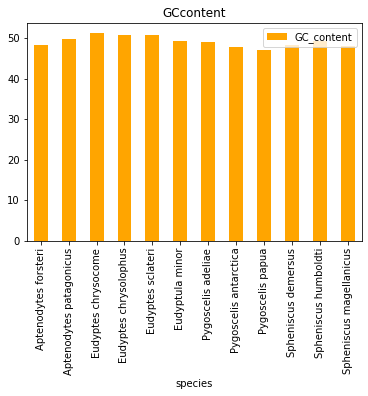

In [49]:
penguins_df.plot(x = "species", y = "GC_content", kind = "bar", color = "orange", 
                title = "GCcontent")

Below I save the changes into a csv file. 

In [50]:
penguins_df.to_csv("penguins_mass_cytb.csv")